## AVIRIS-NG

# Water Mask for Hyperspectral Data using MNDWI and Otsu Thresholding

Hyperspectral imagery from the Airborne Visible InfraRed Imaging Spectrometer-Next Generation (AVIRIS-NG) was collected as part of the Arctic Boreal Vulnerability Experiment (ABoVE) in 2017 - 2019 and archived at the ORNL DAAC. File sizes can be prohibitively large due to the large number of raster bands. 

Reflected radiance was measured by the Airborne Visible/Infrared Imaging Spectrometer-Next Generation (AVIRIS-NG) instrument during flights over the Arctic-Boreal Vulnerability Experiment (ABoVE) domain between June and August 2017. AVIRIS-NG measures reflected radiance at 5 nm intervals in the visible to shortwave infrared spectral range between 380 and 2510 nm. Cloud-free reflectance imagery of 27 individual flight lines was orthorectified and atmospherically corrected using a bidirectional reflectance distribution function<sup>[1]</sup>. Radiometrically and geometrically calibrated reflectance data is provided at approximately 5 m spatial resolution. The data include 422 flight lines covering areas of interest to the ABoVE campaign over much of Alaska and western Canada. 


[1] Greenberg, E. et al. Combined Sun Glint and Vegetation BRDF Correction over Heterogeneous Wetland Land Cover. In prep. 

In [30]:
import numpy as np
import pandas as pd
import os
import json
import math
import affine
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from osgeo import gdal,ogr,osr
from scipy.linalg import norm
import os.path

## 1. Open ENVI file

In [2]:
# open ENVI header file
with open(".../AVIRISNG_Data/ang20170809t211931_new_rfl.hdr","r") as f:
    print("Metadata keys:\n"+", ".join(
        [ln.strip().split(" = ")[0] for ln in f.readlines() if " = " in ln]))

Metadata keys:
description, samples, lines, bands, header offset, file type, data type, interleave, byte order, map info, crosstrack scatter file, wavelength units, flat field file, wavelength file, wavelength, radiance version, fwhm, rcc file, smoothing factors, data ignore value, spectral scatter file, bad pixel map


In [3]:
# open the ENVI file
# Insert your flightline here
img = gdal.Open(".../AVIRISNG_Data/ang20170809t211931_new_rfl")

nbands = img.RasterCount
nrows = img.RasterYSize
ncols = img.RasterXSize

print("\n".join(["Bands:\t"+str(nbands),"Rows:\t"+str(nrows),"Cols:\t"+str(ncols)]))

Bands:	425
Rows:	15166
Cols:	647


## 2. Get band descriptions

In [68]:
# band description
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# function to classify bands
between = lambda wavelength, region: region['lower'] < wavelength <= region['upper']
def classifier(band):
    for region, limits in band_dictionary.items():
        if between(band, limits):
            return(region)

# lists of band numbers, band centers, and em classes
band_numbers = [int(b.split("_")[1]) for b in img.GetMetadata().keys() if b != "wavelength_units"]
band_centers = [float(b.split(" ")[0]) for b in img.GetMetadata().values() if b != "Nanometers"]
em_regions = [classifier(b) for b in band_centers]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band center (nm)": band_centers, 
    "EM region": em_regions }, index = band_numbers).sort_index()

# print the first few rows
bands.head()

,Band number,Band center (nm),EM region
1,1,376.86,visible-violet
2,2,381.87,visible-violet
3,3,386.88,visible-violet
4,4,391.89,visible-violet
5,5,396.89,visible-violet


## 3. Extract bands

In [33]:
# function finds band in our table
get_band_number = lambda w: bands.iloc[(bands["Band center (nm)"]-w).abs().argsort()[1]]

r540, r665, r842, r860, r1240, r1610, r2190, r2220 = (get_band_number(540), get_band_number(665), 
                                                      get_band_number(842), get_band_number(860), 
                                                      get_band_number(1240), get_band_number(1610), 
                                                      get_band_number(2190), get_band_number(2220))

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(r540),str(r665),str(r842),str(r860),
                                    str(r1240),str(r1610),str(r2190),str(r2220)]))

Band number                    34
Band center (nm)           542.15
EM region           visible-green
Name: 34, dtype: object
------------------------------------------------------------
Band number                  59
Band center (nm)         667.36
EM region           visible-red
Name: 59, dtype: object
------------------------------------------------------------
Band number                    94
Band center (nm)           842.67
EM region           near-infrared
Name: 94, dtype: object
------------------------------------------------------------
Band number                    97
Band center (nm)           857.69
EM region           near-infrared
Name: 97, dtype: object
------------------------------------------------------------
Band number                        173
Band center (nm)               1238.35
EM region           shortwave-infrared
Name: 173, dtype: object
------------------------------------------------------------
Band number                        247
Band center (nm)

In [34]:
# function gets numpy array from input band
get_band = lambda b: img.GetRasterBand(int(b["Band number"])).ReadAsArray()

R540, R665, R842, R860, R1240, R1610, R2190, R2220 = (get_band(r540), get_band(r665),
                                                      get_band(r842), get_band(r860),
                                                      get_band(r1240), get_band(r1610),
                                                      get_band(r2190), get_band(r2220))

In [42]:
# set fill value to numpy nan for all -9999.
R540[R540 == -9999.], R665[R665 == -9999.], R842[R842 == -9999.], R860[R860 == -9999.], R1240[R1240 == -9999.], R1610[R1610 == -9999.], R2190[R2190 == -9999.], R2220[R2220 == -9999.] = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

## 4. Water masking algorithms

### Single-band water mask
Single-band water masks are often used to extract surface water bodies.
The most common are:
* 1500 nm
* 2200 nm
* 2220 nm (R2220)

### Normalized Difference Water Index

McFeeters, S. K. The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features. Int. J. Remote Sens. 17, 1425–1432 (1996).

NDWI = (R860-1240)/(R860+1240)

### Modified Normalized Difference Water Index

Xu, H. Modification of normalised difference water index (NDWI) to enhance open water features in remotely sensed imagery. Int. J. Remote Sens. 27, 3025–3033 (2006).

MNDWI = (R540-R1610)/(R540-1610)

Given my experience, I consider the conservative MNDWI, characterized by a reduced noise sensitivity, as a reliable metric to accurately delineate open water features.

------------------------------------------------------------
MNDWI stats --- mean: -0.0044948086, std: 1.0031247, min: -784.83704, max: 965.1797


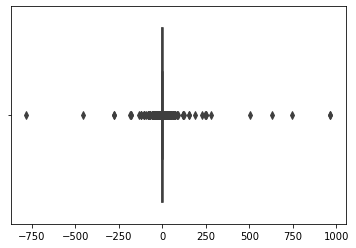

In [45]:
# calculate mndwi
mndwi_array = (R540-R1610)/(R540+R1610)

# print mndwi statistics
print(str("---"*20+"\n")+", ".join([
    "MNDWI stats --- mean: "+str(np.nanmean(mndwi_array)), 
    "std: "+str(np.nanstd(mndwi_array)), 
    "min: "+str(np.nanmin(mndwi_array)), 
    "max: "+str(np.nanmax(mndwi_array)) 
]))

# visualize outliers (often patches of dark green)
ax = sns.boxplot(x=mndwi_array)

### Multi-Band Water Index

Wang, X. et al. A robust Multi-Band Water Index (MBWI) for automated extraction of surface water from Landsat 8 OLI imagery. Int. J. Appl. Earth Obs. Geoinf. 68, 73–91 (2018).

MBWI_array = 2 * R540 - R665 - R842 - R1610 - R2190

## 5. Remove and replace outliers

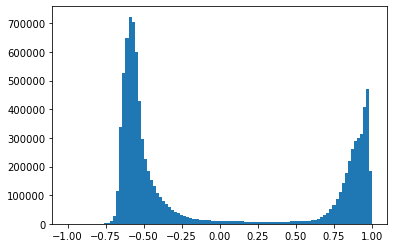

In [50]:
import copy
mndwi_array2 = copy.copy(mndwi_array)
# set all pixels MNDWI < -1 and MNDWI > 1 to nan
mndwi_array2[mndwi_array2 < -1] = np.nan
mndwi_array2[mndwi_array2 > 1] = np.nan

mndwi_squeeze = np.squeeze(np.asarray(mndwi_array2).reshape(-1))
plt.hist(mndwi_squeeze, bins=100);

In [53]:
# Interpolate nan values
from scipy.interpolate import NearestNDInterpolator
mask = np.where(~np.isnan(mndwi_array2))
interp = NearestNDInterpolator(np.transpose(mask), mndwi_array2[mask])
filled_data = interp(*np.indices(mndwi_array2.shape))

## 6. Otsu Thresholding

0.16837427


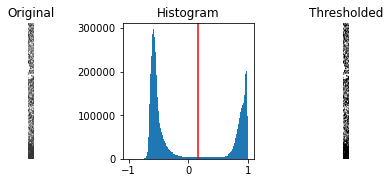

In [69]:
# Find dynamic threshold for flight line
from skimage.filters import threshold_otsu

threshold = threshold_otsu(filled_data)
binary = filled_data > thresh

print(threshold)

# visualize threshold
f, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1) #,adjustable='box-forced')
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0]) #, adjustable='box-forced')

ax[0].imshow(filled_data, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(filled_data.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()
#f.savefig("Otsu.pdf", dpi=300)

## 7. Extract water mask and save as GeoTIFF

In [73]:
watermask = copy.copy(filled_data)
# set all pixels with MNDWI < 0 to 0, keeping only values > 0 (surface water bodies)
# insert Otsu threshold value
watermask[filled_data < threshold] = 0
watermask[filled_data > threshold] = 1 

# print percentage of water bodies within the flight line
print('Mean MNDWI > 0 :',round(np.nanmean(watermask)*100,2))

Mean MNDWI > 0 : 37.25


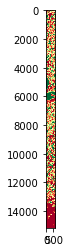

In [74]:
fig = plt.imshow(watermask)
fig.set_cmap('RdYlGn')

In [75]:
# open gdal raster dataset for writing
outraster1 = gdal.GetDriverByName('GTiff').Create(
    "flightline_watermask.tif",                     # output GeoTIFF
    img.RasterXSize,                                # number of columns
    img.RasterYSize,                                # number of rows
    1 ,                                             # number of bands
    gdal.GDT_Float32)                               # data type

# set geotransform and projection information
geo = img.GetGeoTransform()                         # get geotransform from input raster
outraster1.SetGeoTransform(geo)                     # set geotransform
wkt = img.GetProjection()                           # get projection from input raster
outraster1.SetProjection(wkt)                       # set projection 

# get band 1
outraster1b = outraster1.GetRasterBand(1)           # get band 1 of output

# write to band 1
watermask[np.isnan(watermask)] = 0                  # fill np.nan in savi array with -9999.0
outraster1b.WriteArray(watermask)                   # write savi array to band 1;
outraster1b.SetNoDataValue(0)                       # set nodata value to -9999

outraster1.FlushCache()                             # write out
outraster1 = None 

# Important Notes:

## Validation:
Validate computed water maks via visual inspection or with a manual digitized reference mask (sklearn.metrics).

## Clouds:
Clouded areas are not detected by the water mask and do not interfere with the computations. Please, exclude clouded areas or where possible manually delinate ponds and lakes.

## Clean up
Given a 5 m spatial resolution, statistically only water bodies above 100 m<sup>2</sup> are "acceptable". Thus, depending on your application remove pixel cluster <100 m<sup>2</sup>. 